# Black-Scholes and Heston model

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

# Model description

The Black-Scholes model is a model used for pricing European options. An option is a derivative contract, which gives the buyer the right to buy/sell (call/put option) the underlying asset at a specified price at a specified time in the future.

The Black-Scholes (BS) model was developed in 1973 by Fisher Black and Myron Scholes, and in 1997 Scholes and Merton (another pioneer in the field) received the Nobel Prize in Economics (Fischer Black died in 1995, and was therefore not eligible to receive the Nobel Prize).

To be able to derive the model analytically, we need a few things.

**Geometric Brownian Motion (GBM)**: this is a continuous *stochastic proces* where the increments are i.i.d, which means that $(W_{t+s}-W_t)~N(0,t)$. Furthermore, there is a *drift* component, denoted by $\mu$. GBM is given by $dS_t=\mu S_tdt+\sigma S_tdW_t$. This is the stochastic process which we assume that the stock price will follow.

**Itô's lemma**: This can be seen as the stochastic version of the *chain rule*, used in ordinary differential calculus. Assume that $X_t$ follows a 1-dimensional Itô process:

$$X_t=X_0+\int_0^t\mu(X_s,s)ds+\int_0^t\sigma(X_s,s)dW_s\Leftrightarrow dX_t=\mu(X_t,t)dt+\sigma(X_t,t)dW_t$$
Itô's lemma states that if we have another function, $f_t$ that depends on $X_t$ and $t$, its change is given by:
$$df=(\frac{\partial f}{\partial t}+\mu S\frac{\partial f}{\partial S}+\frac{1}{2}\frac{\partial^2 f}{\partial S^2}\sigma^2S^2)dt+\frac{\partial f}{\partial S}\sigma SdW$$


We can now derive the Black-Scholes PDE, which must be solved to obtain the Black-Scholes pricing formula:

Assume we have a portfolio, consisting of one short position in an option and owning a fraction, $\frac{\partial f}{\partial S}$, of stock. This portfolio will be self-financing (no money in or out of the portfolio). This gives the following value of the portfolio at time $t$:
$$\Pi_t=\frac{\partial f}{\partial S}S_t-f_t$$
And the change in value in a very small timeframe, $\Delta t$ is:
$$\Delta\Pi=\frac{\partial f}{\partial S}\Delta S_t-\Delta f_t$$
We also assume that the portfolio is momentarily risk free (since it can be shown that the stochastic component, $dW$ is eliminated), which means that $\Delta\Pi=r\Pi\Delta t$.
Combining this (and using Itô's lemma to represent $\Delta f$) we get:
$$r\Pi\Delta t=\frac{\partial f}{\partial S}(\mu S\Delta t+\sigma S\Delta W)-(\frac{\partial f}{\partial t}+\mu S\frac{\partial f}{\partial S}+\frac{1}{2}\frac{\partial^2 f}{\partial S^2}\sigma^2S^2)\Delta t-\frac{\partial f}{\partial S}\sigma S\Delta W$$
$$\Leftrightarrow r(\frac{\partial f}{\partial S}S-f)\Delta t=-(\frac{\partial f}{\partial t}+\frac{1}{2}\sigma^2S^2)\Delta W$$
$$r\frac{\partial f}{\partial S}+\frac{\partial f}{\partial t}+\frac{1}{2}\sigma^2S^2\frac{\partial^2f}{\partial S^2}-rf=0$$
This is the Black-Scholes PDE that must be solved to obtain the pricing formula.
While the derivation of the solution is not the main focus of the project, the outline of the derivation will still be presented:
By applying the Feynman-Kac theorem (used for PDE's) and boundary conditions for the PDE, which are: $f=\max(S-K,0)$ for $t=T$, $f(0,t)=0$ and $lim_{S\rightarrow\infty}f(S,t)=S$, we can obtain the following:
$$C(S,t)=e^{-r\tau}E^Q[\max(S-K,0)\vert F]$$
Where $Q$ represents the fact that we have changed the probability measure to a risk neutral measure, and $F$ is the information about the stock price up to time $t$.
This can be decomposed into two integrals:
$$e^{-r\tau}\int_K^{\infty}S_TdF(S_T)-e^{-r\tau}\int_K^\infty KdF(S_T)$$
Here, $dF(S_T)$ represents the Gaussian distribution.
The first integral can be solved by realising it is equal to the conditional value
$g(K)=E(X\vert X>k)P(X>k)=e^{\mu+\frac{\sigma^2}{2}}N\left(\frac{\mu+\sigma^2-\ln K}{\sigma}\right)$. 
By inserting values for $\mu=ln S_t+(r-\frac{\sigma^2}{2})$ and $\sigma=\sigma\sqrt{\tau}$ we get:
$$e^{-r\tau}\int_K^\infty S_TdF(S_T)=e^{-r\tau}e^{\ln S_t+(r-\frac{\sigma^2}{2})\tau+\frac{\sigma^2}{2}\tau}N\left(\frac{\ln S_t-\ln K+(r-\frac{\sigma^2}{2})\tau+\sigma^2\tau}{\sigma\sqrt{\tau}}\right)$$
$$=e^{-r\tau}S_te^{r\tau}N\left(\frac{\ln\frac{S_t}{K}+(r+\sigma^2/2)\tau}{\sigma\sqrt{\tau}}\right)=S_tN(d_1)$$
The second integral, $\int_K^\infty KdF(S_T)$ is solved bt:
$$\int_K^\infty KdF(S_T)=K*Q(S_T>K)=K(1-Q(S_T<K))=K(1-F(K)$$
$$=K(1-N\left(\frac{\ln K-\ln S_t-(r-\frac{\sigma^2}{2})}{\sigma}\right))=K(1-N(-d_2)=KN(d_2)$$
Combining this we get:
$$C(S,t)=e^{r\tau}E^Q[\max(S_t-K,0)\vert F_t]=S_tN(d_1)-e^{-r\tau}KN(d_2)$$
Which is the Black-Scholes formula. $N(x)$ is the Gaussian distribution, $d_1=\frac{1}{\sigma\sqrt{\tau}}(\ln(\frac{S_t}{K})+(r+0.5\sigma^2)\tau)$ and $d_2=d_1-\sigma\sqrt{\tau}$


## Analytical solution

The Black-Scholes model, as shown above, does indeed have a nice analytical solution, which is very easy to work with. This analytical solution can be used to compare with the numerical results, which will be derived later.

In [1]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S0, K, T, r, sigma): # Defining the Black-Scholes call-price
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price



# Parameters
S0 = 100    # Current stock price
K = 100     # Strike price
T = 1       # Time to maturity in years
r = 0.05    # Risk-free rate
sigma = 0.2 # Volatility

# Calculate prices
call_price = black_scholes_call(S0, K, T, r, sigma)

# Output the results
print(f"Black-Scholes Call Option Price: {call_price:.2f}")


Black-Scholes Call Option Price: 10.45


As we can see from the analytical solution, the example option with a current stock price of 100, a strike price of 100, 1 year to maturity, a risk free rate of 5% and an annualized volatility of 20% yields a price of 10.45 (the specific currency is essentially irrelevant, and could be in USD, EUR, DKK or anything else). 
Given the simplicity of this analytical solution, there have also been developed a myriad of online "Black-Scholes options calculators", which confirm that this implemenation and result is correct.

## Numerical solution

There are several ways to solve the Black-Scholes model numerically. The simplest is to use Monte Carlo simulation, to calculate many different possible paths that the stock price could theoretically follow, and then use this to approximate the option price. 

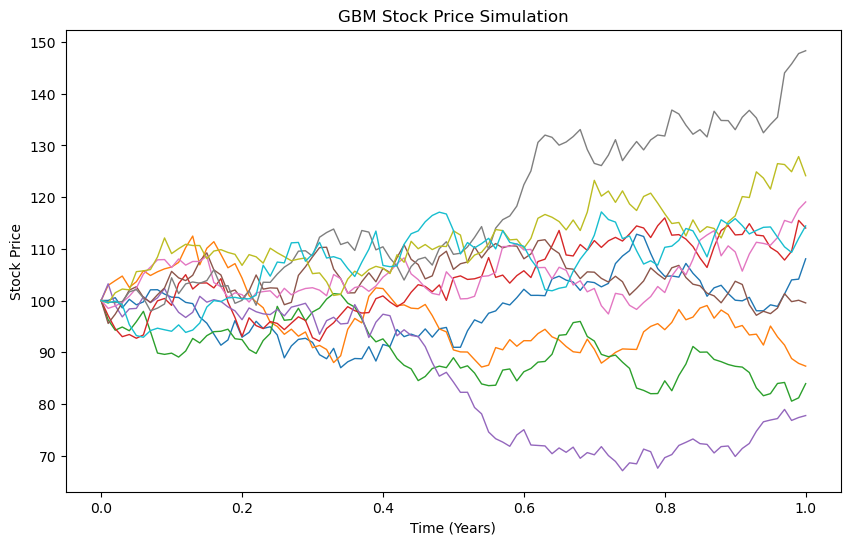

Estimated Call Option Price at Maturity: $10.45


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(S0, T, mu, sigma, dt, N):
    """ Simulate Geometric Brownian Motion trajectories for a stock price. """
    # Time array
    t = np.linspace(0, T, int(T/dt)+1)
    # Initialize the stock price array
    S = np.zeros((N, len(t)))
    S[:, 0] = S0
    
    # Generate stock price paths
    for i in range(1, len(t)):
        Z = np.random.standard_normal(N)  # Generate random values from a standard normal distribution
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return t, S

def calculate_call_option_price(S, K, r, T):
    """ Calculate the European call option price using Monte Carlo method at maturity with discounting. """
    # S is the matrix of simulated paths with the final prices in the last column
    final_prices = S[:, -1]
    payoffs = np.maximum(final_prices - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs  # Discount the payoffs
    option_price = np.mean(discounted_payoffs)
    return option_price

# Parameters
S0 = 100    # Initial stock price
K = 100     # Strike price
T = 1       # Time to maturity in years
mu = 0.05   # Expected return (used for the drift term under real-world measure for simulation)
r = 0.05    # Risk-free rate (used for discounting)
sigma = 0.2 # Volatility
dt = 0.01   # Time step
N = 1000000    # Number of paths

# Simulate stock price
t, S = simulate_gbm(S0, T, mu, sigma, dt, N)

# Calculate the call option price
call_price = calculate_call_option_price(S, K, r, T)

# Plot
plt.figure(figsize=(10, 6))
for i in range(min(10, N)):  # Plot some of the paths
    plt.plot(t, S[i, :], lw=1)
plt.title('GBM Stock Price Simulation')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.show()

# Print the estimated call option price
print("Estimated Call Option Price at Maturity: ${:.2f}".format(call_price))


As we can see from the results, the MC approach does a very good job at approximating the option price, but the downside of this approach is that it is very computationally heavy. When dealing with a relatively simple model, such as the Black-Scholes model, it does not necessarily require that much computation, but for more complex models, it can quickly become infeasible to use this approach, especially if there is an analytical solution to the model. 

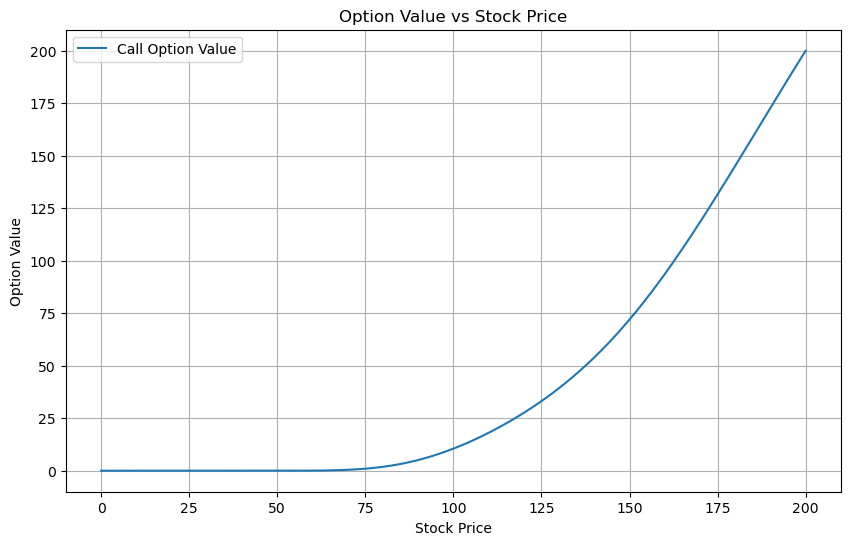

Call Option Price: 10.53


In [27]:
def black_scholes_call(S_max, K, T, r, sigma, dx, dt):
    # Grid size
    N = int(S_max / dx) + 1  # Asset price steps
    M = int(T / dt) + 1  # Time steps
    
    # Grid for stock prices and option values
    S = np.linspace(0, S_max, N)
    V = np.maximum(S - K, 0)  # Intrinsic values for American Call
    V_new = np.zeros_like(V)

    # Coefficients for the finite difference method
    alpha = 0.5 * dt * (sigma**2 * np.arange(N)**2 - r * np.arange(N))
    beta = 1 - dt * (sigma**2 * np.arange(N)**2 + r)
    gamma = 0.5 * dt * (sigma**2 * np.arange(N)**2 + r * np.arange(N))

    # Solving the PDE
    for j in range(M-1):
        for i in range(1, N-1):
            V_new[i] = alpha[i] * V[i-1] + beta[i] * V[i] + gamma[i] * V[i+1]
        V_new[0] = 0  # Boundary condition at S=0 (call is worthless)
        V_new[-1] = S_max - K + (S_max - K) * np.exp(-r * dt * (M-j))  # Far boundary approximation
        
        # Ensure the condition: V = max(V, S - K)
        V = np.maximum(V_new, S - K)

    return S, V

# Parameters
S_max = 200    # Maximum stock price
K = 100        # Strike price
T = 1          # Time to maturity in years
r = 0.05       # Risk-free rate
sigma = 0.2    # Volatility
dx = 1.0       # Space step
dt = 0.0002     # Time step (CFL condition: dt < dx^2/(sigma^2*S_max^2))

# Compute the option prices
S, V = black_scholes_call(S_max, K, T, r, sigma, dx, dt)

# Print results
plt.figure(figsize=(10, 6))
plt.plot(S, V, label="Call Option Value")
plt.title("Option Value vs Stock Price")
plt.xlabel("Stock Price")
plt.ylabel("Option Value")
plt.legend()
plt.grid(True)
plt.show()
print(f"Call Option Price: {V[S == 100][0]:.2f}")


Another approach is the "finite difference" method, where we can approximate the derivatives of the PDE with *finite differences*. As we see, this generates a price for all possible stock prices up to a given value, which in this case was chosen to be 200. 

# Further analysis

An extension of the Black-Scholes model is the Heston model (1993). In this model, the volatility of the underlying asset is no longer assumed to be constant, but is instead assumed to follow a Cox-Ingersoll-Ross (CIR) process. For the sake of brevity, the model will not be derived here, but a good resource for this is Jim Gatheral (2006): *The Volatility surface - A practitioner's guide*. 

In the model, we assume that the stock price follow the stochastic differential equation:
$$dS_t=\mu S_tdt+sqrt{v_t}S_tdW_{1,t}$$
$$dv_t=\kappa(\theta-v_t)dt+\sigma\sqrt{v_t}dW_{2,t}$$
Where the two Wiener processes are correlated with $\rho$. $\kappa$ represents the speed of mean-reversion, $\theta$ is the long-run variance and $\sigma$ is the vol-of-vol.


The price of a call option in the model is given by:
$$C(x,v,t)=S_tP_1-Ke^{-r\tau}P_2$$
Where $P_1$ and $P_2$ represents the probability that the option expires *in-the-money (ITM)*.
The probabilities are risk-neutral.
We rewrite $S_t\rightarrow \ln S_t=x_t$. 

The two probabilities can be represented by an inverse Fourier transformation, given by:

$$P_j(x,v,\tau,K)=\frac{1}{2}+\frac{1}{\pi}\int_0^\infty Re\left(\frac{e^{-i\phi \ln K}f_j(x,v,\tau,\phi)}{i\phi}\right)d\phi$$
$$f_j(x,v,\tau;\phi)=e^{C(\tau;\phi)+D(\tau;\phi)v+i\phi x}$$
Where $i=\sqrt{-1}$, $\phi\in R$ and
$$C(\tau;\phi)=ri\phi\tau+\frac{a}{\sigma^2}\left((b_j-\rho\sigma i \phi-d)\tau-2\ln\left(\frac{1-ge^{dr}}{1-g}\right)\right)$$
$$D(\tau;\phi)=\frac{(b_j-\rho\sigma i\phi-d)(1-e^{-dr})}{\sigma^2(1-ge^{-dr})}$$
$$d=\sqrt{(b_j-\rho\sigma i \phi)^2-\sigma^2(2\phi u_ji-\phi^2)}$$
$$g=\frac{b_j-\rho\sigma i\phi-d}{b_j-\rho\sigma i\phi+d}$$
$$u_1=\frac{1}{2},\quad u_2=-\frac{1}{2},\quad a=\kappa\theta,\quad b_1=\kappa-\rho\sigma,\quad b_2=\kappa$$


There are several ways to go about using the Heston model.
One way is to calibrate the model using a large dataset of options prices, in order to calibrate the parameters of the model. This is usually required since the model's parameters cannot be directly observed in the market.

Another method is to use Monte Carlo simulations to approximate the price. This requires knowledge about the parameters, but to illustrate the method itself I will simply assume some values for the parameters.

To compare the Monte Carlo simulation with the analytical solution, we still need to implement the solution itself, which can be quite a challenge, since it is not just a simple integral that needs to be calculated.

In [15]:
import scipy.integrate as integrate
import cmath

def heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r):
    """ Returns the characteristic function for the Heston model. """
    i = complex(0, 1)
    d = cmath.sqrt((rho * sigma * i * u - kappa)**2 + (sigma**2) * (i * u + u**2))
    g = (kappa - rho * sigma * i * u - d) / (kappa - rho * sigma * i * u + d)
    
    C = r * i * u * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * i * u - d) * T - 2 * cmath.log((1 - g * cmath.exp(-d * T))/(1 - g)))
    D = (kappa - rho * sigma * i * u - d) / sigma**2 * ((1 - cmath.exp(-d * T)) / (1 - g * cmath.exp(-d * T)))
    
    return cmath.exp(C + D * v0 + i * u * cmath.log(S0))

def heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, lambda_=0):
    " Calculates the Heston model price of a call option. "
    i = complex(0, 1)
    integrand = lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u - i, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u * heston_char_function(-i, T, S0, v0, kappa, theta, sigma, rho, r))).real
    integral = integrate.quad(integrand, 0, np.inf)[0]
    return S0 * (0.5 + integral/np.pi) - K * np.exp(-r * T) * (0.5 + integrate.quad(lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u)).real, 0, np.inf)[0] / np.pi)

# parameters guesses
S0 = 100     # asset price
K = 100      # Strike price
T = 1        # Time to maturity
r = 0     # Risk-free rate
kappa = 1.0  # Rate of mean reversion
theta = 0.09  # Long-term variance
sigma = 1  # vol-of-vol
rho = -0.3   # Correlation
v0 = 0.09    # Initial variance

# Calculate the call price
price = heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
print("The price of the European call option is:", price)


The price of the European call option is: 9.77379032877068


As we can see, the price of the option (using these parameter values) is 9.77, which is what the MC simulation will be compared against.

Option value:  10.318268154685633


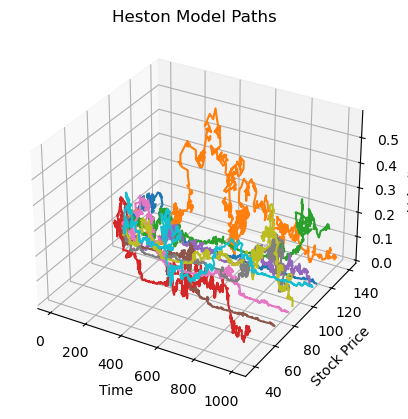

Option value:  10.318268154685633


In [24]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

# Define parameters

N = 1000  # number of simulation paths
M = 1000  # number of time steps
dt = T / M  # time step size

# Define the function for the Heston model
def heston(s0, v0, kappa, theta, sigma, rho, r, T, M, N):
    # Initialize arrays
    S = np.zeros((M + 1, N))
    V = np.zeros((M + 1, N))
    S[0, :] = s0
    V[0, :] = v0

    # Generate correlated Brownian motions
    z1 = np.random.normal(size=(M, N))
    z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=(M, N))

    # Generate stock price and volatility paths
    for t in range(1, M + 1):
        # Calculate the drift and volatility
        drift = r * S[t - 1, :]
        vol = np.sqrt(V[t - 1, :])

        # Update the stock price and volatility
        S[t, :] = S[t - 1, :] * np.exp((drift - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z1[t - 1, :])
        V[t, :] = np.maximum(
            0.0, V[t - 1, :] + kappa * (theta - V[t - 1, :]) * dt + sigma * np.sqrt(V[t - 1, :]) * np.sqrt(dt) * z2[t - 1, :]
        )

    # Calculate the option payoff at maturity
    payoff = np.maximum(S[-1, :] - K, 0)

    # Calculate the option value using the LSM method
    for t in range(M - 1, 0, -1):
        # Calculate the cash flows and exercise values
        cash_flows = np.zeros(N)
        exercise_values = np.zeros(N)
        for i in range(N):
            if payoff[i] > 0:
                cash_flows[i] = payoff[i] * np.exp(-r * (T - t) / (M - t))
                exercise_values[i] = payoff[i]

        # Calculate the continuation values
        x = np.log(S[t, :] / K)
        y = np.sqrt(V[t, :])
        X = np.column_stack((np.ones(N), x, x ** 2, x ** 3, x ** 4))
        X_inv = np.linalg.inv(np.dot(X.T, X))
        beta = np.dot(X_inv, np.dot(X.T, cash_flows))
        continuation_values = np.dot(X, beta)

        # Determine the optimal exercise policy
        early_exercise = exercise_values > continuation_values
        payoff[early_exercise] = exercise_values[early_exercise]

    # Calculate the option value using Monte Carlo simulation
    discount_factor = np.exp(-r * T)
    option_value = discount_factor * np.mean(payoff)

    return option_value

# Value the American-style option using the Heston model and Monte Carlo simulation
option_value = heston(S0, V0, kappa, theta, sigma, rho, r, T, M, N)
print("Option value: ", option_value)

# Generate a 4D graph of the Heston model paths
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Heston Model Paths")
ax.set_xlabel("Time")
ax.set_ylabel("Stock Price")
ax.set_zlabel("Volatility")
S = np.zeros((M + 1, N))
V = np.zeros((M + 1, N))
S[0, :] = S0
V[0, :] = V0
z1 = np.random.normal(size=(M, N))
z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=(M, N))

# Generate stock price and volatility paths
for t in range(1, M + 1):
    # Calculate the drift and volatility
    drift = r * S[t - 1, :]
    vol = np.sqrt(V[t - 1, :])

    # Update the stock price and volatility
    S[t, :] = S[t - 1, :] * np.exp((drift - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z1[t - 1, :])
    V[t, :] = np.maximum(
        0.0, V[t - 1, :] + kappa * (theta - V[t - 1, :]) * dt + sigma * np.sqrt(V[t - 1, :]) * np.sqrt(dt) * z2[t - 1, :]
    )

for i in range(10):
    ax.plot(np.arange(M + 1), S[:, i], V[:, i])
plt.show()

# Print information about the simulation
print("Option value: ", option_value)

| N\M     | 10             | 100             | 1.000           | 10.000          |
| ------- | -------------- | --------------- | --------------- | --------------- |
| 100     | 2.81 (0.3 sec) | 1.16 (0.5 sec)  | 1.75 (0.7 sec)  | 1.82 (3.3 sec)  |
| 1.000   | 2.18 (0.3 sec) | 1.11 (0.5 sec)  | 0.27 (2.9 sec)  | 0.73 (25.9 sec) |
| 10.000  | 1.70 (0.5 sec) | 0.82 (2.8 sec)  | 0.40 (27.5 sec) | 0.54 (403 sec)  |
| 100.000 | 1.87 (2.9 sec) | 0.78 (28.3 sec) | 0.41 (352 sec)  | X               |

These are the results from several different Monte Carlo simulations. The first value is the absolute price error, and the second value is the runtime in seconds. Of course, the results may vary if ran again.

As we can see, the performance of the simulations gets better the more simulation paths are used and the more discrete time intervals used.

# Conclusion

In this project, the Black-Scholes model has been derived and explored. The model has been solved analytically, and the option price has also been approximated using both MC simulations and *finite differences*. 

The Heston model has also been evaluated, and this option price has been calculated analytically as well as by using the Monte Carlo method. As it can be seen, the MC method is computationally heavy, but if one can approximate the parameters in the model, it can be a viable method to calculate the option price. 